In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_palette("colorblind")
base_path = Path("results")
plot_path = base_path / "plots"
plot_path.mkdir(parents=True, exist_ok=True)

FONT_SIZE = "large"

In [3]:
df_service = pd.read_csv(base_path / "service.csv")
df_link = pd.read_csv(base_path / "link.csv")
df_infra = pd.read_csv(base_path / "infrastructure.csv")
df_sim = pd.read_csv(base_path / "simulation.csv")

dfs = {"service": df_service, "link": df_link, "infrastructure": df_infra, "simulation": df_sim}

In [4]:
for df in dfs.values():
    df = df.astype({"n_event": np.int32, "value": np.int32})

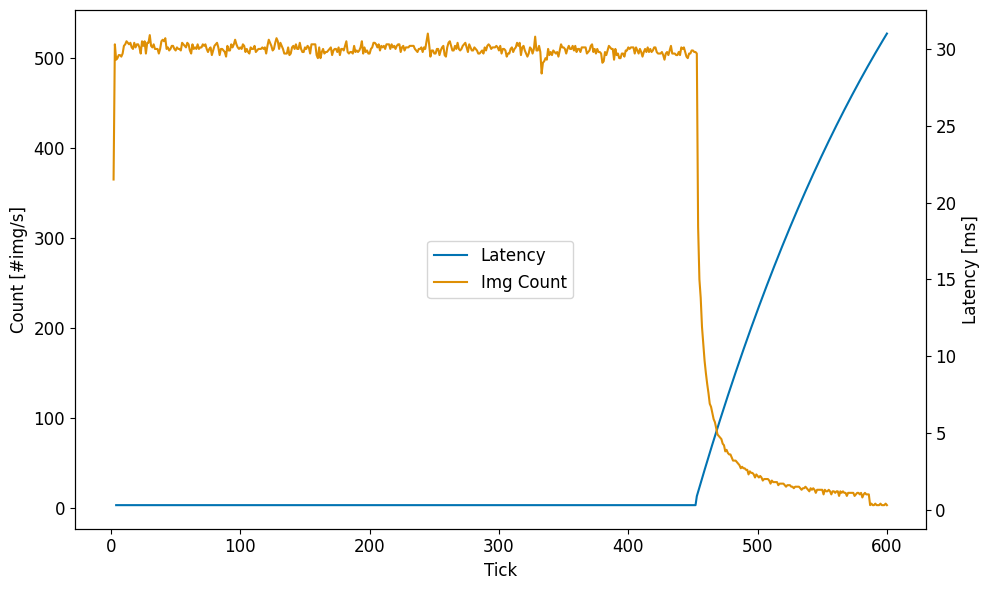

In [12]:
df_count = df_service[df_service["callback_id"] == "img_counter"].copy().loc[3:]
df_lat = df_infra[df_infra["callback_id"] == "featured_latency_mean"].copy().loc[3:]

fig, ax1 = plt.subplots(figsize=(10, 6))
palette = sns.color_palette("colorblind")[:2]
l1 = sns.lineplot(
    data=df_lat,
    x="n_event",
    y="value",
    ax=ax1,
    label="Latency",
    color=palette[0],
)
ax2 = ax1.twinx()

l2 = sns.lineplot(
    data=df_count,
    x="n_event",
    y=df_count["value"] / 10,
    ax=ax2,
    label="Img Count",
    color=palette[1],
    legend=None,
)


# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Create a single legend
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="center",
    fontsize=FONT_SIZE,
    frameon=True,
)
ax1.set_xlabel("Tick", fontsize=FONT_SIZE)
ax1.set_ylabel("Count [#img/s]", fontsize=FONT_SIZE)
ax2.set_ylabel("Latency [ms]", fontsize=FONT_SIZE)

ax1.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
ax2.tick_params(axis="both", which="major", labelsize=FONT_SIZE)

plt.tight_layout()
plt.savefig(plot_path / "latency_num_imgs.pdf", dpi=600, format="pdf")
plt.show()

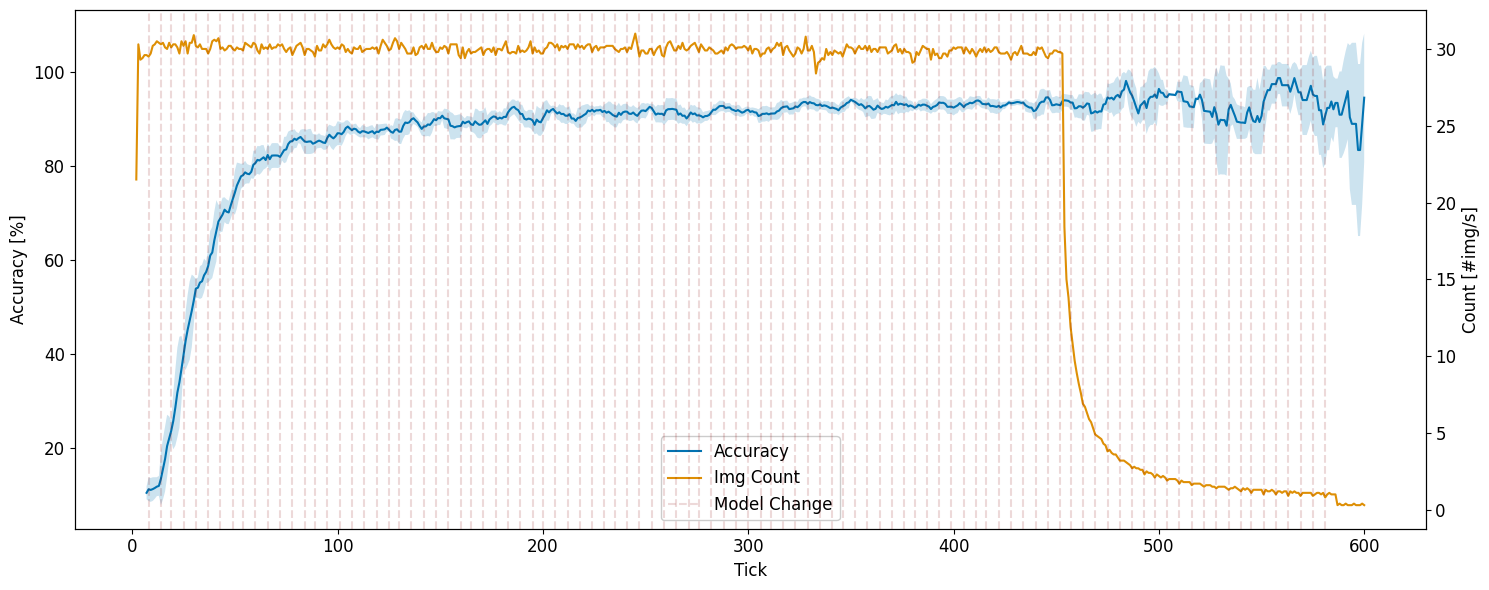

In [13]:
window = 6
df_acc = df_service[df_service["callback_id"] == "accuracy"].copy().loc[3:]
df_acc["avg"] = df_acc["value"].rolling(window).mean() * 100
df_acc["std"] = df_acc["value"].rolling(window).std() * 100

df_mc = df_service[df_service["callback_id"] == "model_change"].copy().loc[3:]

fig, ax1 = plt.subplots(figsize=(15, 6))
palette = sns.color_palette("colorblind")[:2]
l1 = sns.lineplot(
    data=df_acc, x="n_event", y="avg", label="Accuracy", ax=ax1, color=palette[0]
)
plt.fill_between(
    df_acc["n_event"],
    df_acc["avg"] - df_acc["std"],
    df_acc["avg"] + df_acc["std"],
    alpha=0.2,
)

l1.set_xlabel("Tick", fontsize=FONT_SIZE)
l1.set_ylabel("Accuracy [%]", fontsize=FONT_SIZE)

ax2 = ax1.twinx()
l2 = sns.lineplot(
    data=df_count,
    x="n_event",
    y=df_count["value"] / 10,
    ax=ax2,
    label="Img Count",
    color=palette[1],
    legend=None,
)

l2.set_xlabel("Tick", fontsize=FONT_SIZE)
l2.set_ylabel("Count [#img/s]", fontsize=FONT_SIZE)

to_label = True
for i, row in df_mc.iterrows():
    if row["n_event"] > window:
        ax2.axvline(
            row["n_event"],
            color="darkred",
            linestyle="--",
            alpha=0.15,
            label=("Model Change" if to_label else None),
        )
        to_label = False

# Combine legends from both axes
lines_labels_1 = ax1.get_legend_handles_labels()
lines_labels_2 = ax2.get_legend_handles_labels()

# Concatenate both handles and labels to create a single legend
lines = lines_labels_1[0] + lines_labels_2[0]
labels = lines_labels_1[1] + lines_labels_2[1]

# Place the legend
ax1.legend(lines, labels, fontsize=FONT_SIZE, loc="lower center", framealpha=1)
ax1.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
ax2.tick_params(axis="both", which="major", labelsize=FONT_SIZE)

# plt.legend(fontsize="large", loc="upper left")
plt.tight_layout()
plt.savefig(plot_path / "accuracy.pdf", dpi=600, format="pdf")
plt.show()

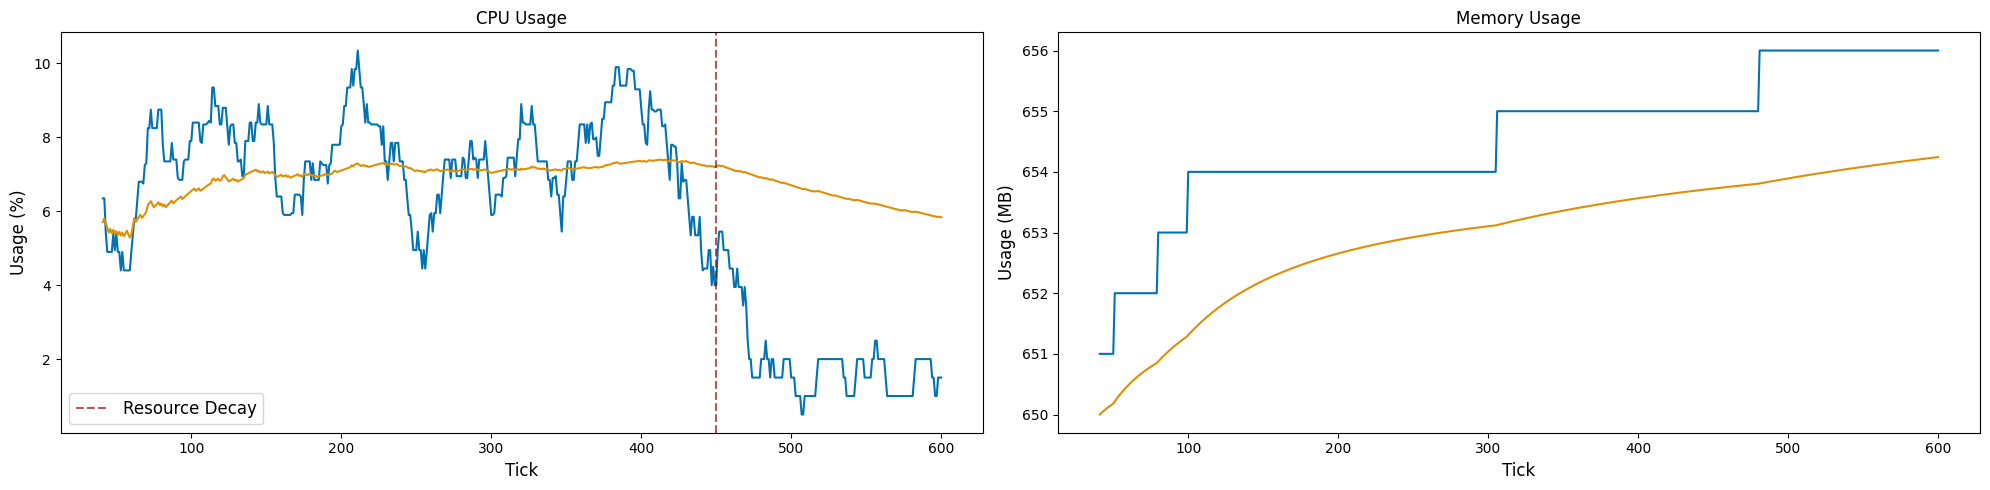

In [7]:

start_tick = 40
df_sim = df_sim.astype({"n_event": np.int32, "value": np.int32})

df_cpu = df_sim[(df_sim["callback_id"] == "cpu_usage")].copy()
df_cpu["avg"] = df_cpu["value"].rolling(window=20).mean()
df_cpu["smooth"] = df_cpu["value"].expanding().mean()

df_mem = df_sim[(df_sim["callback_id"] == "memory_usage") & (df_sim["event_id"] != "stop")].copy()
df_mem["avg"] = df_mem["value"].expanding().mean()
df_mem["fluctuation"] = (df_mem["value"].diff().abs() / df_mem["value"].shift(1)) * 100

df_cpu = df_cpu[df_cpu["n_event"] > start_tick]
df_mem = df_mem[df_mem["n_event"] > start_tick]

_, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.lineplot(data=df_cpu, x="n_event", y="avg", ax=axes[0])
f = sns.lineplot(data=df_cpu, x="n_event", y="smooth", ax=axes[0])
f.axvline(450, color="darkred", linestyle="--", alpha=0.65, label="Resource Decay")
f.legend(loc="lower left", fontsize=FONT_SIZE)

axes[0].set_title("CPU Usage", fontsize=FONT_SIZE)
axes[0].set_xlabel("Tick", fontsize=FONT_SIZE)
axes[0].set_ylabel("Usage (%)", fontsize=FONT_SIZE)

sns.lineplot(data=df_mem, x="n_event", y="value", ax=axes[1])
sns.lineplot(data=df_mem, x="n_event", y="avg", ax=axes[1])

axes[1].set_title("Memory Usage", fontsize=FONT_SIZE)
axes[1].set_xlabel("Tick", fontsize=FONT_SIZE)
axes[1].set_ylabel("Usage (MB)", fontsize=FONT_SIZE)

# sns.lineplot(data=df_mem, x="n_event", y="fluctuation", ax=axes[2])

# axes[2].set_title("Memory Fluctuation", fontsize=FONT_SIZE)
# axes[2].set_xlabel("Tick", fontsize=FONT_SIZE)
# axes[2].set_ylabel("Fluctuation (%)", fontsize=FONT_SIZE)

plt.tight_layout()
plt.savefig(plot_path / "resource_usage.pdf", dpi=600, format="pdf")
plt.show()

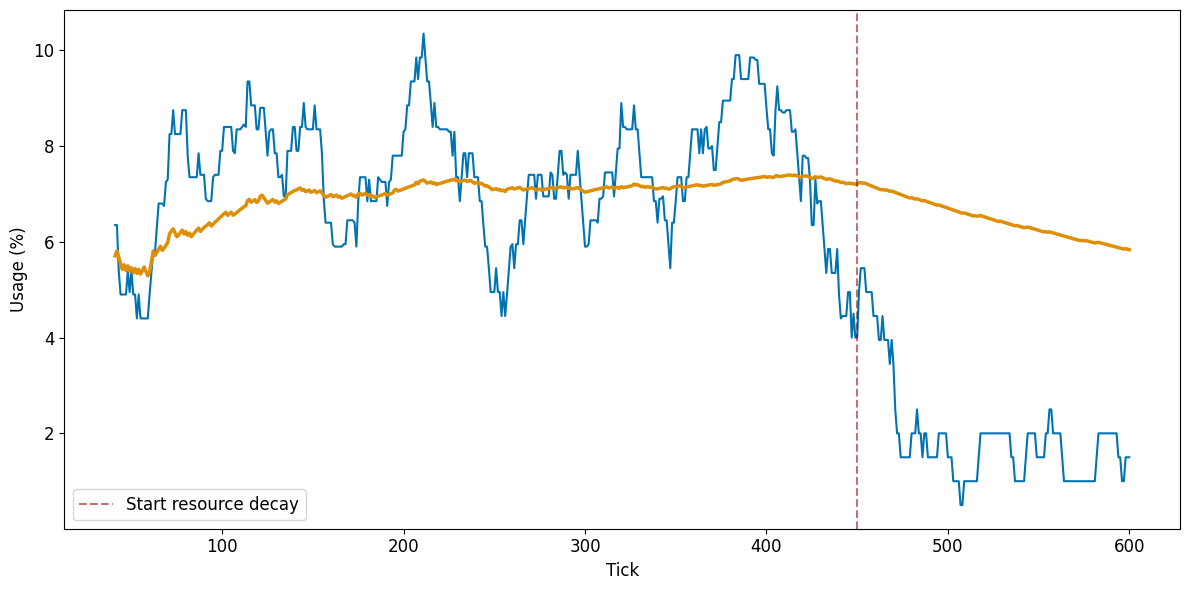

In [14]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=df_cpu, x="n_event", y="avg")
sns.lineplot(data=df_cpu, x="n_event", y="smooth", linewidth=2.5)
plt.axvline(450, color="darkred", linestyle="--", alpha=0.55, label="Start resource decay")
plt.legend(loc="lower left", fontsize=FONT_SIZE)

# plt.title("CPU Usage", fontsize=FONT_SIZE)
plt.xlabel("Tick", fontsize=FONT_SIZE)
plt.ylabel("Usage (%)", fontsize=FONT_SIZE)
plt.tick_params(axis="both", which="major", labelsize=FONT_SIZE)

plt.tight_layout()
plt.savefig(plot_path / "cpu_usage.pdf", dpi=600, format="pdf")
plt.show()